# Social Network Analysis

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# conformance
from pm4py.algo.conformance.footprints import algorithm as fp_conformance
from pm4py import conformance_diagnostics_token_based_replay
from pm4py.algo.conformance.alignments.edit_distance import algorithm as logs_alignments

# misc 
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.petri_net.obj import PetriNet, Marking

import pm4py

In [3]:
events_array = [[1, "Bestellen", pd.to_datetime("01/01/1970"),"Sue"],
          [1, "Servieren", pd.to_datetime("01/02/1970"),"Alan"],
          [1, "Kassieren", pd.to_datetime("01/03/1970"),"Sara"],
          [2, "Bestellen", pd.to_datetime("01/01/1970"),"Cara"],
          [2, "Servieren", pd.to_datetime("01/02/1970"),"Alan"],
          [2, "Kassieren", pd.to_datetime("01/03/1970"),"Sara"],
          ]

In [4]:
events = pd.DataFrame(events_array, columns=[ 'case:concept:name', 'concept:name', 'time:timestamp', 'org:resource'])

In [5]:
log = log_converter.apply(events)

In [6]:
# footprint
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
footprint = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
footprint['sequence']




{('Bestellen', 'Servieren'), ('Servieren', 'Kassieren')}

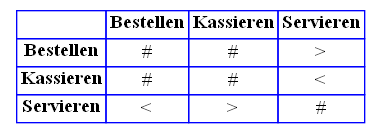

In [7]:
from pm4py.visualization.footprints import visualizer as fp_visualizer

gviz = fp_visualizer.apply(footprint)
fp_visualizer.view(gviz)

In [8]:
hw_values = pm4py.discover_handover_of_work_network(log, beta=0)

c:\Program Files\Anaconda3\lib\site-packages\pm4py\utils.py:503: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [9]:
# hw_values to dataframe
connections=hw_values.connections
names = list(set([connection[0] for connection in connections]+[connection[1] for connection in connections]))
rows = []
for name in names:
    cols = []
    for subname in names:
        try:
            cols.append(connections[(name, subname)])
        except KeyError:
            cols.append(0)
    rows.append(cols)
rows

df = pd.DataFrame(rows, index=names, columns=names)
df

,Cara,Sue,Alan,Sara
Cara,0,0,0.25,0.0
Sue,0,0,0.25,0.0
Alan,0,0,0.00,0.5
Sara,0,0,0.00,0.0


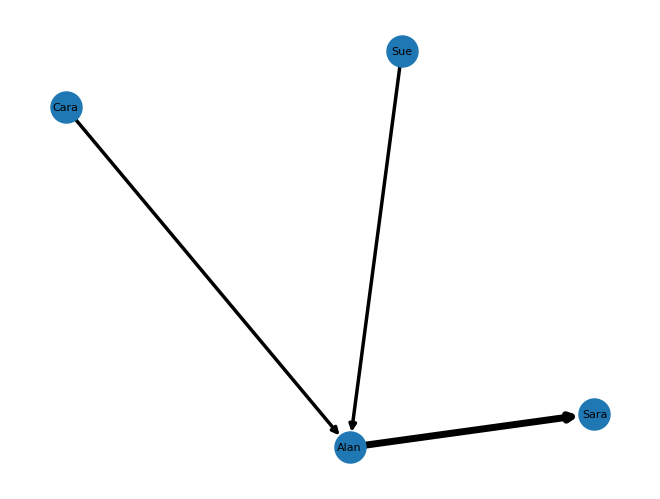

In [10]:
# depict distances as network with networkx
G_hw = nx.from_numpy_array(np.array(df.values), create_using=nx.DiGraph)
G_hw = nx.relabel_nodes(G_hw, dict(zip(range(len(names)), names)))
mywidth = [i * 10 for i in list(nx.get_edge_attributes(G_hw,'weight').values())]
nx.draw(G_hw, with_labels=True, node_size=500, font_size=8, width=mywidth)

In [11]:
# degree centrality for edges in G_hw that ignores edge weights
nx.degree_centrality(G_hw)

{'Cara': 0.3333333333333333,
 'Sue': 0.3333333333333333,
 'Alan': 1.0,
 'Sara': 0.3333333333333333}

In [12]:
# degree centrality for edges in G_hw considering edge weights
G_hw.degree(weight='weight')

DiDegreeView({'Cara': 0.25, 'Sue': 0.25, 'Alan': 1.0, 'Sara': 0.5})

In [13]:
# add distance attribute to G_hw
g_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G_hw.edges(data='weight')}
nx.set_edge_attributes(G_hw, g_distance_dict, 'distance')

In [14]:
nx.betweenness_centrality(G_hw, weight='distance', normalized=False)

{'Cara': 0.0, 'Sue': 0.0, 'Alan': 2.0, 'Sara': 0.0}

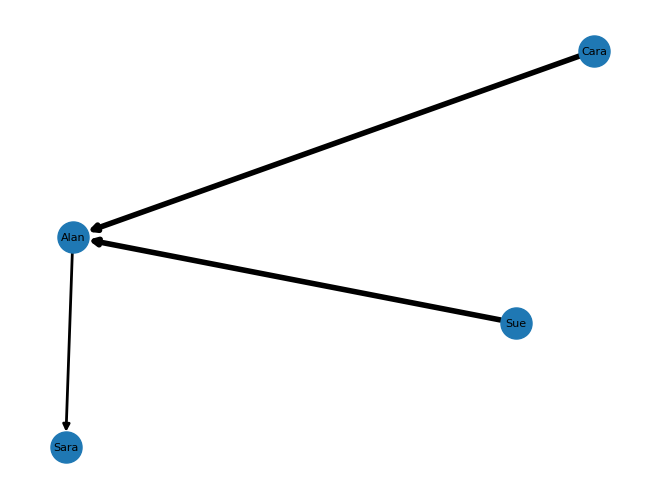

In [15]:
mydistance = [i  for i in list(nx.get_edge_attributes(G_hw,'distance').values())]
nx.draw(G_hw, with_labels=True, node_size=500, font_size=8, width=mydistance)